In [1]:
# --- Bloco 0: Importações ---
# Quase idêntico, mas removemos MinMaxScaler e joblib
import pandas as pd
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn (para pré-processamento e métricas)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Optuna (para otimização de hiperparâmetros)
import optuna
import plotly.graph_objects as go
from optuna.trial import TrialState

# Outros
import math
import time
import matplotlib.pyplot as plt

# Configurações
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
torch.manual_seed(42)

C:\Users\Danone\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cpu


In [2]:
# --- Bloco 1: Definição da Arquitetura da Rede (Dinâmica) ---
# Este bloco é IDÊNTICO ao anterior. A arquitetura da rede
# não muda, apenas os dados que entram nela.

class Net(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(Net, self).__init__()
        
        layers = []
        
        # Camada de entrada (1 feature: Potencia_MW)
        layers.append(nn.Linear(1, n_neurons))
        layers.append(nn.ReLU())
        
        # Camadas ocultas dinâmicas
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())
            
        # Camada de saída (1 feature: Custo_Real)
        layers.append(nn.Linear(n_neurons, 1))
        
        # Compilar todas as camadas em um modelo sequencial
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Definição da classe 'Net' concluída.")

Definição da classe 'Net' concluída.


In [3]:
# --- Bloco 2: Funções Auxiliares (Métricas e Complexidade) ---
# Este bloco é IDÊNTICO ao anterior.

def calculate_complexity(n_layers, n_neurons):
    """
    Calcula a métrica de complexidade customizada:
    log2(número de neurônios por camada) * número de camadas
    """
    if n_neurons == 0 or n_layers == 0:
        return 0
    return math.log2(n_neurons) * n_layers

def calculate_all_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE e MAPE.
    Espera arrays NumPy.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

print("Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.")

Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.


In [4]:
# --- Bloco 3: Carregamento dos Dados (SEM NORMALIZAÇÃO) ---

# Carregar o dataset
df = pd.read_csv('usina_carvao_dataset.csv')

# Preparar dados
# **MUDANÇA AQUI**: Estamos usando os valores REAIS, não normalizados.
X = df[['Potencia_MW']].values
y = df[['Custo_Real']].values

# *** NENHUM SCALER É USADO. ***
# *** NENHUM ARQUIVO .joblib É SALVO. ***

print("Dados carregados. NENHUMA normalização foi aplicada.")
print(f"Formato de X (Potência): {X.shape}. Ex: {X[0]}")
print(f"Formato de y (Custo): {y.shape}. Ex: {y[0]}")

Dados carregados. NENHUMA normalização foi aplicada.
Formato de X (Potência): (5000, 1). Ex: [182.18737264]
Formato de y (Custo): (5000, 1). Ex: [17569.69010836]


In [5]:
# --- Bloco 4: Separação Aleatória e DataLoaders ---
# Este bloco mistura os dados e os separa,
# usando os dados brutos (X, y).

# Separar em treino (80%) e validação (20%)
# **MUDANÇA AQUI**: Usando X e y diretamente.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Converter dados NumPy para Tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Criar DataLoaders para treinamento em lote (batch)
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dados separados: {len(X_train_t)} amostras de treino, {len(X_val_t)} amostras de validação.")

Dados separados: 4000 amostras de treino, 1000 amostras de validação.


In [6]:
# --- Bloco 5: Definição da Função 'objective' do Optuna ---
# IDÊNTICO ao anterior, mas note que os valores de 'loss' 
# e 'rmse' reportados serão muito maiores, pois estão na
# escala real (R$).

# Parâmetros do Treinamento
N_EPOCHS = 300       
EARLY_STOPPING_PATIENCE = 30 

def objective(trial):
    # --- 1. Sugerir Hiperparâmetros ---
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_neurons = trial.suggest_int('n_neurons', 3, 20)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    
    # --- 2. Calcular Complexidade e Armazenar ---
    complexity = calculate_complexity(n_layers, n_neurons)
    trial.set_user_attr('complexity', complexity)

    # --- 3. Construir Modelo e Otimizador ---
    model = Net(n_layers, n_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() 

    # --- 4. Loop de Treinamento com Early Stopping & Pruning ---
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        # Treinamento
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # --- Possível Ponto de Falha ---
            # Se o loss for NaN (explodir), podemos podar o trial
            if torch.isnan(loss):
                raise optuna.TrialPruned()
                
            loss.backward()
            optimizer.step()
        
        # Validação
        model.eval()
        current_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_val_loss += loss.item() * X_batch.size(0)
        
        current_val_loss /= len(val_loader.dataset)
        
        # Se a validação falhar (NaN), pare
        if np.isnan(current_val_loss):
            raise optuna.TrialPruned()

        # --- 5. Lógica de Pruning (pelo Optuna) ---
        trial.report(current_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # --- 6. Lógica de Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            break
            
    # --- 7. Retornar Métrica de Qualidade (RMSE) ---
    final_rmse = math.sqrt(best_val_loss)
    trial.set_user_attr('val_rmse', final_rmse)
    
    return final_rmse

print("Função 'objective' do Optuna definida.")

Função 'objective' do Optuna definida.


In [7]:
# --- Bloco 6: Execução do Estudo Optuna ---
# IDÊNTICO ao anterior.

print("--- Iniciando Estudo Optuna (Sem Normalização) ---")
# Habilitar o Pruner (Poda) para cortar trials ruins
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n--- Estudo Optuna Concluído ---")
print(f"Melhor trial: {study.best_trial.number}")
print(f"  Melhor RMSE de Validação (em R$): {study.best_value:.2f}") # Agora em R$
print("  Melhores Hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
    
complexity = study.best_trial.user_attrs['complexity']
print(f"  Complexidade do Melhor Modelo: {complexity:.2f}")

[I 2025-10-27 20:38:40,082] A new study created in memory with name: no-name-c2a5451d-7bdb-4fee-a757-a5f6c21146d4


--- Iniciando Estudo Optuna (Sem Normalização) ---


Best trial: 0. Best value: 27.9234:   5%|▌         | 1/20 [00:28<09:08, 28.89s/it]

[I 2025-10-27 20:39:08,986] Trial 0 finished with value: 27.923449416999862 and parameters: {'n_layers': 2, 'n_neurons': 16, 'lr': 0.00754413334588538}. Best is trial 0 with value: 27.923449416999862.


Best trial: 0. Best value: 27.9234:  10%|█         | 2/20 [00:51<07:30, 25.01s/it]

[I 2025-10-27 20:39:31,276] Trial 1 finished with value: 45.22460153483251 and parameters: {'n_layers': 2, 'n_neurons': 13, 'lr': 0.06311113219836875}. Best is trial 0 with value: 27.923449416999862.


Best trial: 0. Best value: 27.9234:  15%|█▌        | 3/20 [01:02<05:20, 18.83s/it]

[I 2025-10-27 20:39:42,751] Trial 2 finished with value: 106.63109599367579 and parameters: {'n_layers': 3, 'n_neurons': 8, 'lr': 0.04335927895152331}. Best is trial 0 with value: 27.923449416999862.


Best trial: 0. Best value: 27.9234:  20%|██        | 4/20 [01:29<05:52, 22.05s/it]

[I 2025-10-27 20:40:09,729] Trial 3 finished with value: 2807.3653698797384 and parameters: {'n_layers': 2, 'n_neurons': 6, 'lr': 0.00010194876391429191}. Best is trial 0 with value: 27.923449416999862.


Best trial: 0. Best value: 27.9234:  25%|██▌       | 5/20 [01:37<04:14, 16.98s/it]

[I 2025-10-27 20:40:17,727] Trial 4 finished with value: 428.2926207629545 and parameters: {'n_layers': 2, 'n_neurons': 4, 'lr': 0.08632702744471998}. Best is trial 0 with value: 27.923449416999862.


Best trial: 0. Best value: 27.9234:  30%|███       | 6/20 [01:38<02:41, 11.50s/it]

[I 2025-10-27 20:40:18,591] Trial 5 pruned. 


Best trial: 0. Best value: 27.9234:  35%|███▌      | 7/20 [01:39<01:44,  8.07s/it]

[I 2025-10-27 20:40:19,593] Trial 6 pruned. 


Best trial: 0. Best value: 27.9234:  40%|████      | 8/20 [01:44<01:25,  7.17s/it]

[I 2025-10-27 20:40:24,827] Trial 7 pruned. 


Best trial: 0. Best value: 27.9234:  45%|████▌     | 9/20 [01:45<00:57,  5.24s/it]

[I 2025-10-27 20:40:25,834] Trial 8 pruned. 


Best trial: 0. Best value: 27.9234:  50%|█████     | 10/20 [01:46<00:38,  3.89s/it]

[I 2025-10-27 20:40:26,685] Trial 9 pruned. 


Best trial: 0. Best value: 27.9234:  55%|█████▌    | 11/20 [01:47<00:27,  3.05s/it]

[I 2025-10-27 20:40:27,847] Trial 10 pruned. 


Best trial: 0. Best value: 27.9234:  60%|██████    | 12/20 [01:48<00:19,  2.38s/it]

[I 2025-10-27 20:40:28,703] Trial 11 pruned. 


Best trial: 0. Best value: 27.9234:  65%|██████▌   | 13/20 [01:49<00:13,  1.96s/it]

[I 2025-10-27 20:40:29,702] Trial 12 pruned. 


Best trial: 0. Best value: 27.9234:  70%|███████   | 14/20 [01:50<00:10,  1.68s/it]

[I 2025-10-27 20:40:30,712] Trial 13 pruned. 


Best trial: 0. Best value: 27.9234:  75%|███████▌  | 15/20 [01:51<00:07,  1.52s/it]

[I 2025-10-27 20:40:31,868] Trial 14 pruned. 


Best trial: 0. Best value: 27.9234:  80%|████████  | 16/20 [01:53<00:06,  1.65s/it]

[I 2025-10-27 20:40:33,831] Trial 15 pruned. 


Best trial: 0. Best value: 27.9234:  85%|████████▌ | 17/20 [01:54<00:04,  1.46s/it]

[I 2025-10-27 20:40:34,839] Trial 16 pruned. 


Best trial: 0. Best value: 27.9234:  90%|█████████ | 18/20 [01:55<00:02,  1.32s/it]

[I 2025-10-27 20:40:35,849] Trial 17 pruned. 


Best trial: 0. Best value: 27.9234:  95%|█████████▌| 19/20 [01:56<00:01,  1.19s/it]

[I 2025-10-27 20:40:36,715] Trial 18 pruned. 


Best trial: 0. Best value: 27.9234: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it]

[I 2025-10-27 20:40:37,871] Trial 19 pruned. 

--- Estudo Optuna Concluído ---
Melhor trial: 0
  Melhor RMSE de Validação (em R$): 27.92
  Melhores Hiperparâmetros:
    n_layers: 2
    n_neurons: 16
    lr: 0.00754413334588538
  Complexidade do Melhor Modelo: 8.00


In [8]:
# --- Bloco 7: Gráficos Elaborados do Optuna ---
# IDÊNTICO ao anterior. Note que os eixos Y
# dos gráficos de RMSE terão valores altos (em R$).

print("Gerando gráficos do Optuna...")

# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# Gráfico 2: Importância dos Hiperparâmetros
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)
trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
complexities = [t.user_attrs['complexity'] for t in trials]
val_rmses = [t.value for t in trials]
trial_numbers = [t.number for t in trials]

fig3 = go.Figure(data=go.Scatter(
    x=complexities,
    y=val_rmses,
    mode='markers',
    text=[f'Trial: {n}<br>RMSE: {r:.2f}<br>Complex: {c:.2f}' 
          for n, r, c in zip(trial_numbers, val_rmses, complexities)],
    marker=dict(
        color=val_rmses,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='RMSE de Validação (R$)')
    )
))
fig3.update_layout(
    title='Trade-off: Qualidade (RMSE) vs. Complexidade (Sem Normalização)',
    xaxis_title='Complexidade (log2(neurônios) * camadas)',
    yaxis_title='RMSE de Validação (R$)',
    hovermode='closest'
)
fig3.show()

Gerando gráficos do Optuna...


In [9]:
# --- Bloco 8: Treinamento Final da Rede "Campeã" ---
# IDÊNTICO ao anterior, mas o 'model' se torna 'final_model' na
# linha de treino (outputs = final_model(X_batch))

print("--- Treinando a Rede 'Campeã' Final (Sem Normalização) ---")

# Pegar os melhores parâmetros
best_params = study.best_params
final_model = Net(
    n_layers=best_params['n_layers'],
    n_neurons=best_params['n_neurons']
).to(device)
final_lr = best_params['lr']

optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
criterion = nn.MSELoss()

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

# Usar os mesmos parâmetros do Optuna
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
for epoch in range(N_EPOCHS):
    # Treinamento
    final_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # **MUDANÇA AQUI**: model -> final_model
        outputs = final_model(X_batch) 
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    final_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        # Damos um nome diferente para não sobrescrever o outro
        torch.save(final_model.state_dict(), 'final_model_sem_norm.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento final parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        # O loss aqui será um número enorme (ex: 1500000.00), e isso é esperado
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {train_losses[-1]:,.2f}, Val Loss: {val_losses[-1]:,.2f}")

end_time = time.time()
print(f"Treinamento final concluído em {end_time - start_time:.2f}s")
print("Modelo 'final_model_sem_norm.pth' salvo.")

--- Treinando a Rede 'Campeã' Final (Sem Normalização) ---
Epoch [50/300], Train Loss: 337,930.44, Val Loss: 331,807.67
Epoch [100/300], Train Loss: 94,751.54, Val Loss: 89,223.96
Epoch [150/300], Train Loss: 13,417.26, Val Loss: 12,293.68
Epoch [200/300], Train Loss: 13,434.42, Val Loss: 11,323.38
Treinamento final parou cedo no epoch 206
Treinamento final concluído em 19.00s
Modelo 'final_model_sem_norm.pth' salvo.


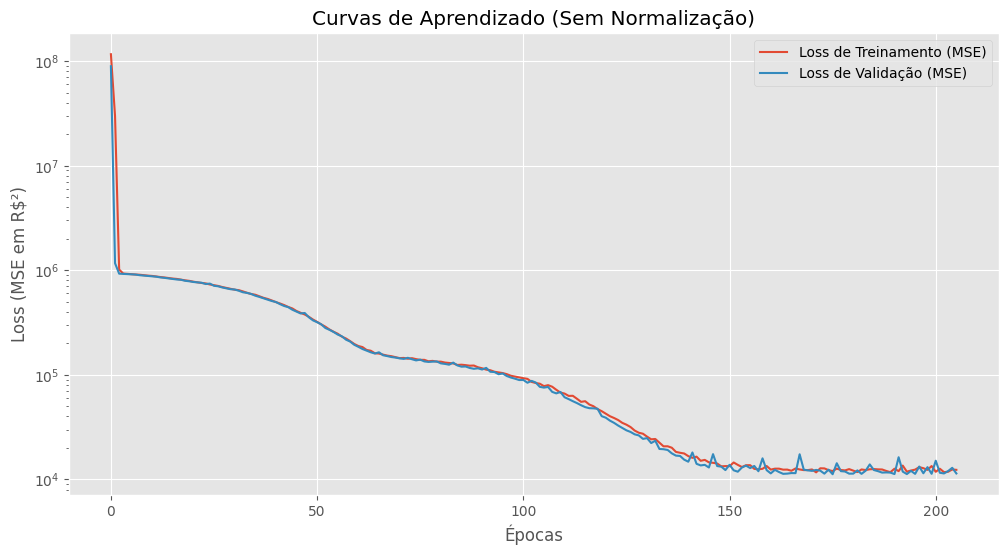

In [10]:
# --- Bloco 9: Gráfico de Treinamento (Loss vs. Epoch) ---
# IDÊNTICO. O eixo Y terá valores muito altos.

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Loss de Treinamento (MSE)')
plt.plot(val_losses, label='Loss de Validação (MSE)')
plt.title('Curvas de Aprendizado (Sem Normalização)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE em R$²)')
plt.yscale('log') # Usar escala logarítmica é quase obrigatório aqui
plt.legend()
plt.show()

--- Avaliação Final do Modelo (Sem Normalização) ---

Métricas Finais (em escala real de R$):
  MSE:  11,429.38
  RMSE: 106.91
  MAPE: 0.0140 %


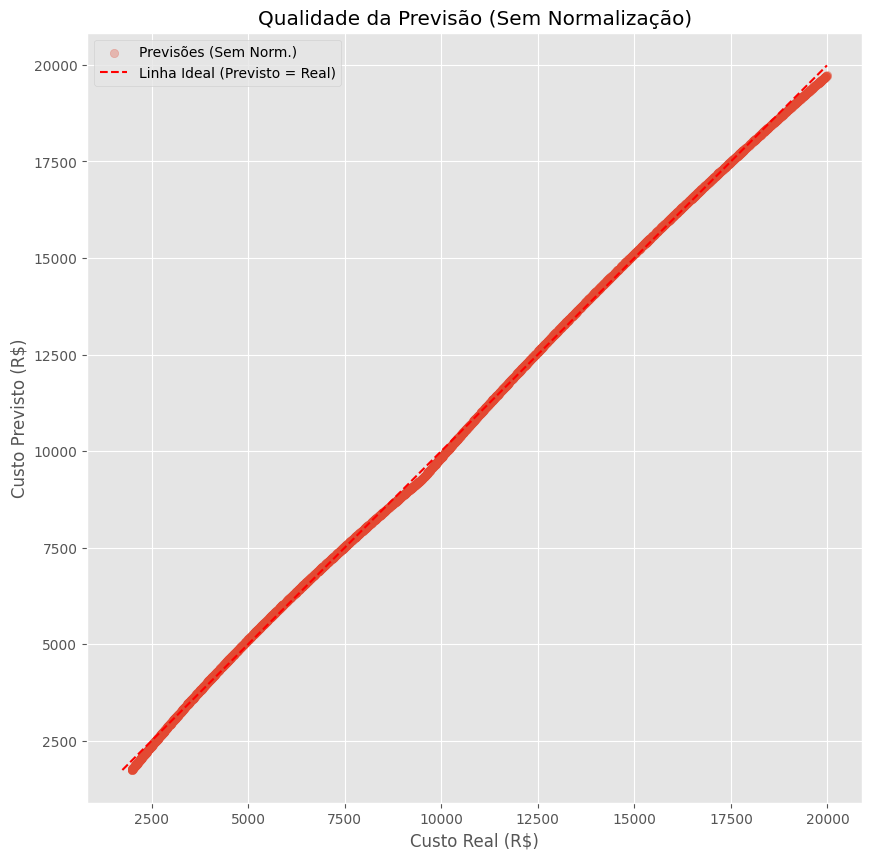

In [11]:
# --- Bloco 10: Avaliação Final (Métricas nos Dados Reais) ---
# Este bloco é muito MAIS SIMPLES, pois não há
# normalização para reverter.

print("--- Avaliação Final do Modelo (Sem Normalização) ---")

# Carregar o melhor modelo salvo
final_model.load_state_dict(torch.load('final_model_sem_norm.pth'))
final_model.eval()

# Passar TODOS os dados (X) pelo modelo
with torch.no_grad():
    y_pred_t = final_model(torch.tensor(X, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_real = y_pred_t.cpu().numpy()
# y_true_real é simplesmente y
y_true_real = y
x_real = X

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões (Sem Norm.)')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Sem Normalização)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()